In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler

import joblib
torch.manual_seed(42)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [13]:
train_data=pd.read_csv('./assets/processed dataset/train dataset.csv')
validation_data=pd.read_csv('./assets/processed dataset/validation dataset.csv')
validation_data.head()

,PRECTOT,QV2M,T2M_MAX,T2M_MIN
0,0.0,3.55,22.99,8.58
1,0.0,3.56,23.24,9.58
2,0.0,3.98,22.89,8.34
3,0.0,5.12,22.99,10.75
4,0.0,5.47,24.10,10.47


In [14]:
#Data scaling
scaler=MinMaxScaler()
normalized_train_data=scaler.fit_transform(train_data)
joblib.dump(scaler, "./assets/scaler.gz") 
print(scaler.scale_)
print(normalized_train_data[0])
normalized_validation_data=scaler.transform(validation_data)
print(normalized_validation_data[0])

[0.01221598 0.0656168  0.03913894 0.04288165]
[0.         0.22440945 0.2704501  0.35034305]
[0.         0.17847769 0.7592955  0.64193825]


In [5]:
#Prepearing X and Y for training and validation
# Setting THE SEQUENCE LENGTH 
seq_length=180
#initialized to a empty 1d list
X_train=[]
Y_train=[]
X_validate=[]
Y_validate=[]
for i in range(seq_length,train_data.shape[0]):
    #Data from 0 to 59TH index
    X_train.append(normalized_train_data[i-seq_length:i])
    #T2M AT THE 60TH index
    Y_train.append(normalized_train_data[i])

for i in range(seq_length,validation_data.shape[0]):
    #Data from 0 to 59TH index
    X_validate.append(normalized_validation_data[i-seq_length:i])
    #T2M AT THE 60TH index
    Y_validate.append(normalized_validation_data[i])

# converting into numpy arrays
X_train,Y_train=np.array(X_train),np.array(Y_train)
#change to 2d array from 1d array
Y_train=Y_train.reshape(-1,4)
print(X_train.shape,Y_train.shape)

X_validate,Y_validate=np.array(X_validate),np.array(Y_validate)
Y_validate=Y_validate.reshape(-1,4)
print(X_validate.shape,Y_validate.shape)

X_train = Variable(torch.Tensor(X_train))
Y_train = Variable(torch.Tensor(Y_train))
print(X_train.shape,Y_train.shape)

X_validate = Variable(torch.Tensor(X_validate))
Y_validate = Variable(torch.Tensor(Y_validate))
print(X_validate.shape,Y_validate.shape)

(9789, 180, 4) (9789, 4)
(1956, 180, 4) (1956, 4)


torch.Size([9789, 180, 4]) torch.Size([9789, 4])
torch.Size([1956, 180, 4]) torch.Size([1956, 4])


In [6]:
#single lstm Network definition
class NETWORK_SINGLE_LSTM(nn.Module):

    def __init__(self,num_classes,input_size,hidden_size,num_layers):
        super(NETWORK_SINGLE_LSTM,self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm=nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True).to(device)
        self.fc=nn.Linear(hidden_size,num_classes)
    
    def forward(self,x):
        output_lstm, (h_n,c_n) = self.lstm(x)
        input_fc=output_lstm[:,-1,:]
        output_fc=self.fc(input_fc).to(device)
        return output_fc

In [7]:
#Initializing model with parameters
num_epochs=500
learning_rate=0.01
input_size=4
hidden_size=8
num_layers=1
num_classes=4

model=NETWORK_SINGLE_LSTM(num_classes,input_size, hidden_size,num_layers)
model.to(device)

NETWORK_SINGLE_LSTM(
  (lstm): LSTM(4, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=4, bias=True)
)

In [8]:
# DEFINE OPTIMIZER
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Lists to store training losses for plotting the training curve
train_losses = []
valid_losses=[]
#batch gradient descent
# TRAIN THE MODEL:
for epoch in range(1,num_epochs+1):
    model.train()
    outputs = model(X_train.to(device))
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, Y_train.to(device))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    model.eval()
    with torch.no_grad():
        valid_outputs=model(X_validate.to(device))
        valid_loss=criterion(valid_outputs,Y_validate.to(device))
        valid_losses.append(valid_loss.item())
    if epoch % 1 == 0:
        print("Epoch: %d, training loss: %1.5f, validation loss: %1.5f" % (epoch, loss.item(),valid_loss.item()))
    

Epoch: 1, training loss: 0.41463, validation loss: 0.36355
Epoch: 2, training loss: 0.37146, validation loss: 0.32962
Epoch: 3, training loss: 0.33697, validation loss: 0.30078
Epoch: 4, training loss: 0.30773, validation loss: 0.27534
Epoch: 5, training loss: 0.28200, validation loss: 0.25240
Epoch: 6, training loss: 0.25884, validation loss: 0.23137
Epoch: 7, training loss: 0.23763, validation loss: 0.21182
Epoch: 8, training loss: 0.21793, validation loss: 0.19348
Epoch: 9, training loss: 0.19948, validation loss: 0.17618
Epoch: 10, training loss: 0.18208, validation loss: 0.15977
Epoch: 11, training loss: 0.16559, validation loss: 0.14418
Epoch: 12, training loss: 0.14994, validation loss: 0.12938
Epoch: 13, training loss: 0.13511, validation loss: 0.11544
Epoch: 14, training loss: 0.12116, validation loss: 0.10248
Epoch: 15, training loss: 0.10818, validation loss: 0.09061
Epoch: 16, training loss: 0.09631, validation loss: 0.07996
Epoch: 17, training loss: 0.08566, validation los

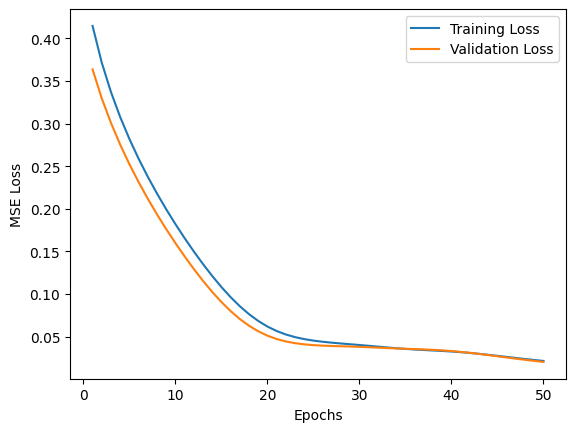

In [9]:
# Plotting the training curve
epochs=range(1,num_epochs+1)
st=0;end=50
plt.plot( epochs[st:end],train_losses[st:end], label='Training Loss')
plt.plot(epochs[st:end],valid_losses[st:end], label='Validation Loss')
# plt.plot(epochs, train_losses, label='Training Loss')
# plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [10]:
torch.save(model.state_dict(),'./assets/trained models state/single_lstm_state.pt')